# Deep Learning with PyTorch : Build a Generative Adversarial Network

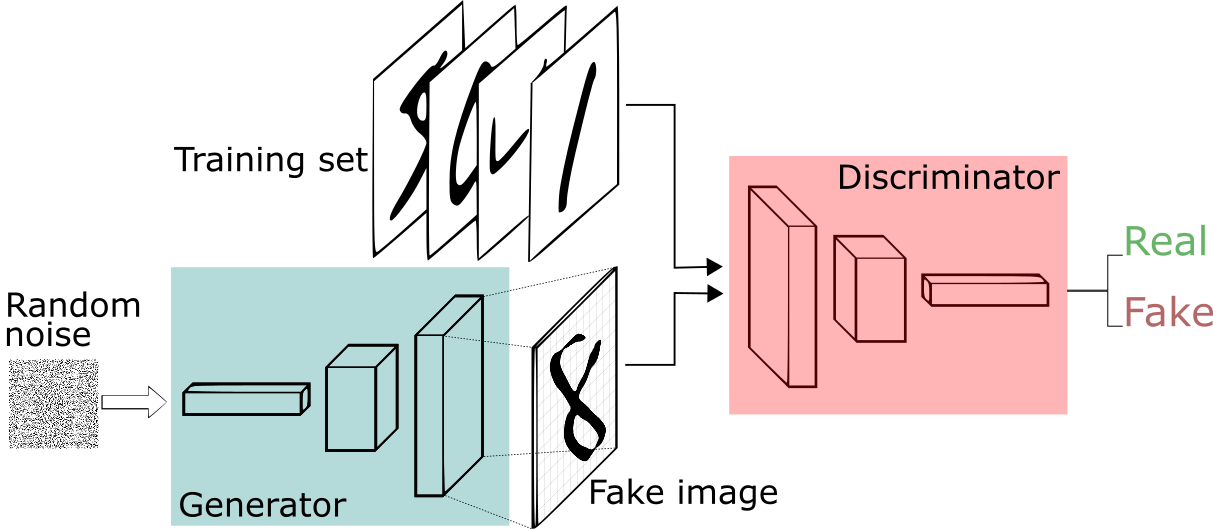

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device='cuda' # image - image.to(device)
batch_size=128 # trainloader, training loop
noise_dim=64 # generator model

#optimizer parameters

lr=0.0002
beta_1=0.5
beta_2=0.99

#Training variables
epochs=20



# Load MNIST Dataset

In [3]:
from torchvision import datasets,transforms as T

In [4]:
train_augs=T.Compose([

                      T.RandomRotation((-20,+20)),
                      T.ToTensor(),#(h,w,c) ->(c,h,w)

])


In [5]:
trainset=datasets.MNIST('MNIST/',download=True,train =True,transform=train_augs)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.62MB/s]


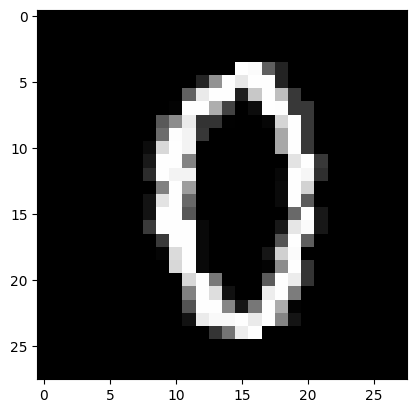

In [6]:
image,label=trainset[1000]
plt.imshow(image.squeeze(),cmap='gray')


In [7]:
print("total images present in trainset are: ",len(trainset))

total images present in trainset are:  60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [10]:
print("Total_no. of batches in Trainloader: ",len(trainloader))

Total_no. of batches in Trainloader:  469


In [11]:
dataiter=iter(trainloader)
images,_=next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

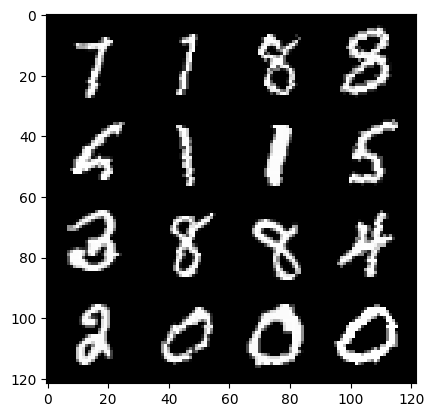

In [13]:
show_tensor_images(images,num_images=16)

# Create Discriminator Network

In [14]:

!pip install torchsummary

In [15]:
from torch import nn
from torchsummary import summary

In [16]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [17]:
def get_dis_block(in_channels,out_channels,kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0,2)
      )

In [18]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1=get_dis_block(1,16,(3,3),2)
    self.block_2=get_dis_block(16,32,(5,5),2)
    self.block_3=get_dis_block(32,64,(5,5),2)

    self.dlatten=nn.Flatten()
    self.linear=nn.Linear(in_features=64,out_features=1)

  def forward(self,images):
    x1=self.block_1(images)
    x2=self.block_2(x1)
    x3=self.block_3(x2)

    x4=self.dlatten(x3)
    x5=self.linear(x4)

    return x5

In [19]:
D= Discriminator()
D.to(device)
summary(D,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [20]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [21]:
def get_gen_block(in_channels,out_channels,kernel_size,stride,final_block=False):
  if final_block ==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
     )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride= stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
      )

In [22]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim=noise_dim
    self.block_1=get_gen_block(noise_dim,256,(3,3),2)
    self.block_2=get_gen_block(256,128,(4,4),1)
    self.block_3=get_gen_block(128,64,(3,3),2)
    self.block_4=get_gen_block(64,1,(4,4),2,final_block=True)
  def forward(self,r_noise_vec):
    #(bs,noise_dim)_> (bs,noise_dim,1,1)
    x= r_noise_vec.view(-1,noise_dim,1,1)
    x1=self.block_1(x)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.block_4(x3)

    return x4

In [23]:
G=Generator(noise_dim)
G.to(device)
summary(G,input_size=(noise_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [24]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [25]:
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (block_1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

# Create Loss Function and Load Optimizer

In [37]:
def real_loss(disc_pred):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss

In [31]:
D_opt=torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))
G_opt=torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:1 | D_loss:0.6774429640790293 | G_loss: 0.7173858628090002


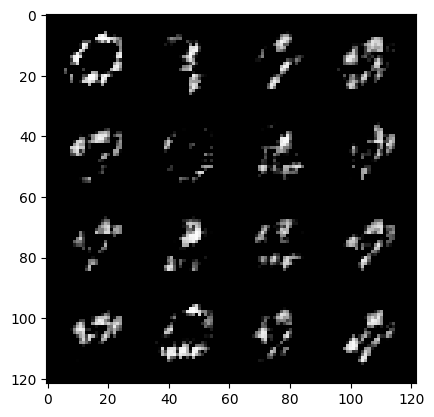

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:2 | D_loss:0.6560755716458059 | G_loss: 0.7431527475304187


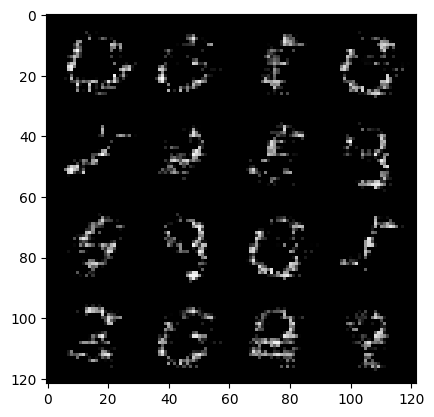

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:3 | D_loss:0.5905327239016226 | G_loss: 0.8242379163882372


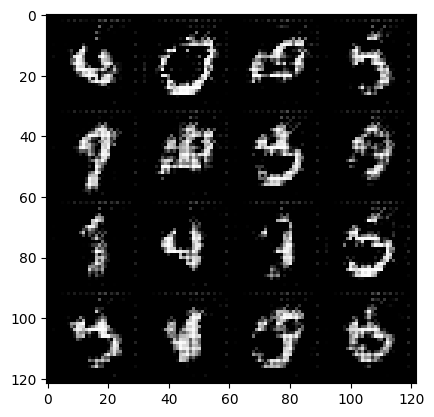

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:4 | D_loss:0.5708799252886254 | G_loss: 0.8625584806460561


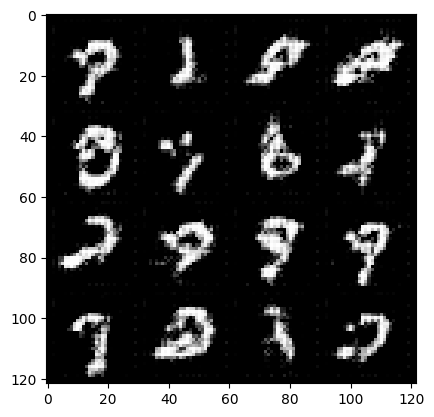

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:5 | D_loss:0.5863169108880862 | G_loss: 0.8546760870195401


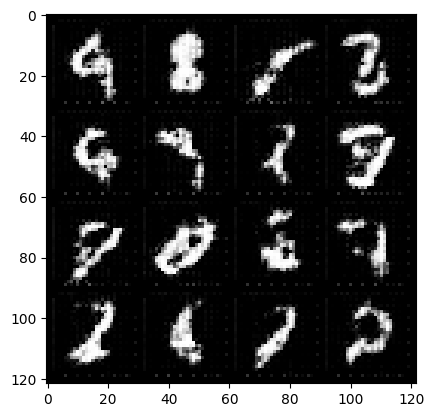

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:6 | D_loss:0.6128661087326912 | G_loss: 0.8251551908216497


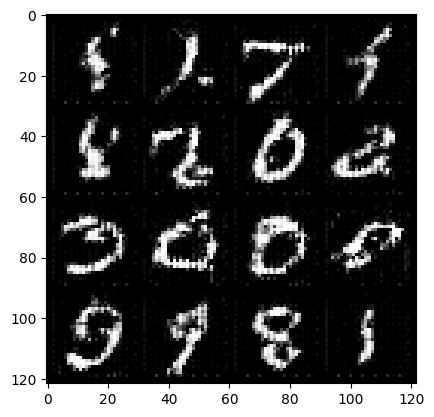

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:7 | D_loss:0.6342500363077436 | G_loss: 0.8003144942875355


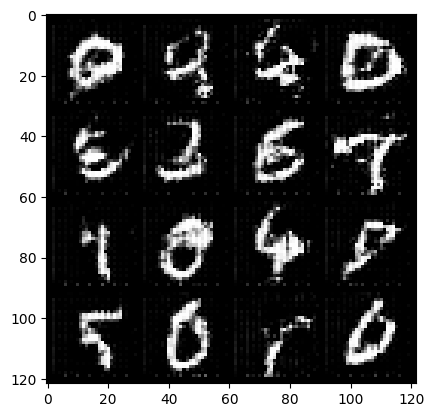

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:8 | D_loss:0.6281855632501371 | G_loss: 0.8106436608696798


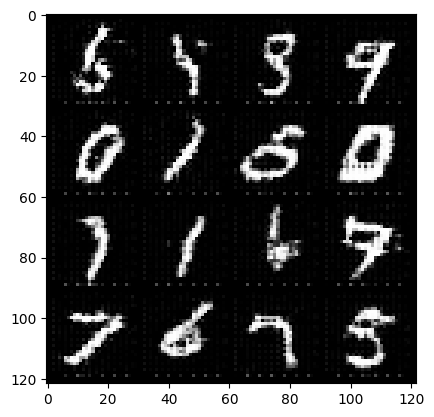

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:9 | D_loss:0.6271129303903722 | G_loss: 0.8165857969824948


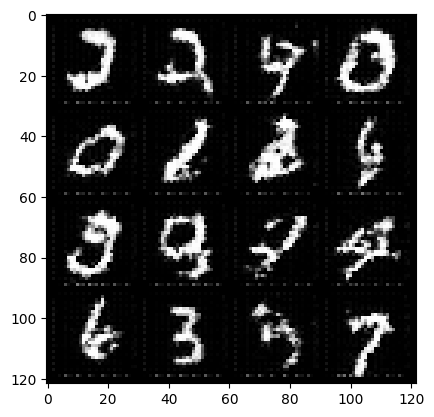

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:10 | D_loss:0.6396808405674851 | G_loss: 0.8005345651844163


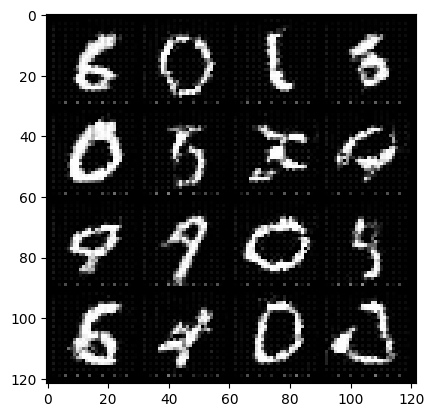

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:11 | D_loss:0.6452945663984905 | G_loss: 0.7969033784195304


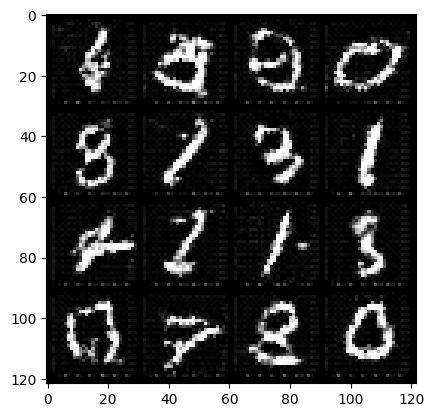

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:12 | D_loss:0.647422465180029 | G_loss: 0.79499208456926


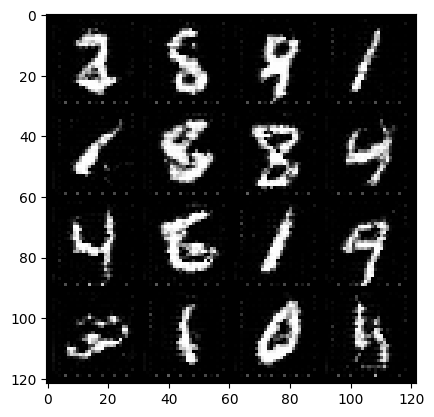

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:13 | D_loss:0.6452099946516154 | G_loss: 0.7999160155050282


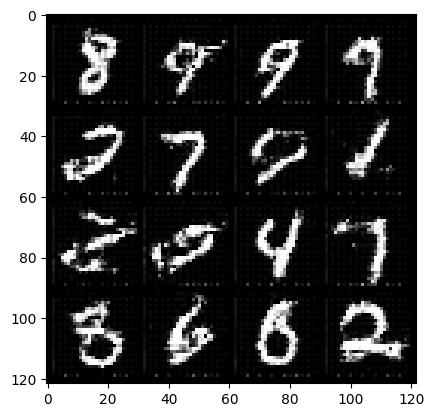

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:14 | D_loss:0.6341481539232137 | G_loss: 0.8165648666017854


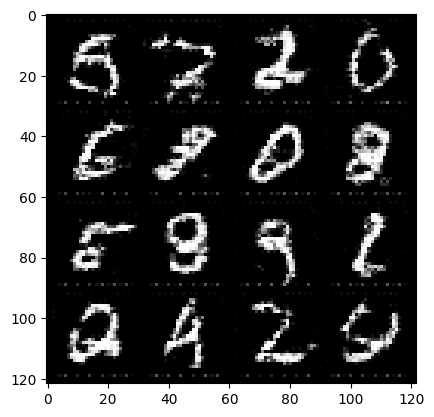

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:15 | D_loss:0.602987317261157 | G_loss: 0.8739626720261726


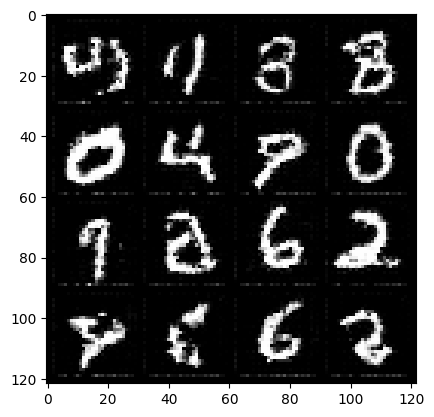

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:16 | D_loss:0.6066619235315303 | G_loss: 0.865541252373124


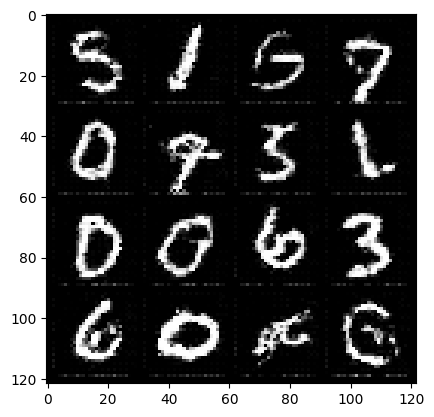

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:17 | D_loss:0.6307200073941684 | G_loss: 0.8392387035050626


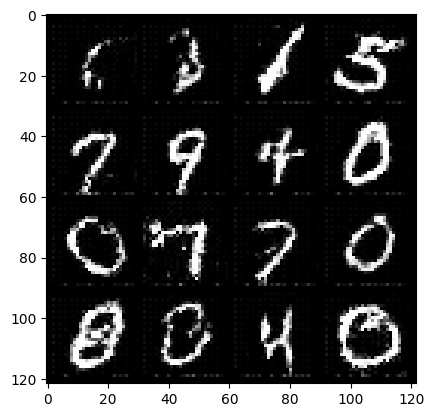

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:18 | D_loss:0.6404312585970995 | G_loss: 0.8238735019779408


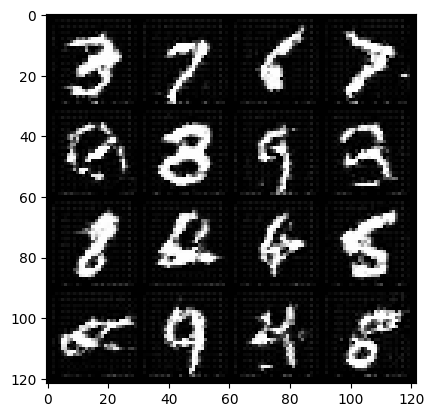

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:19 | D_loss:0.6416933990236539 | G_loss: 0.8254651076503908


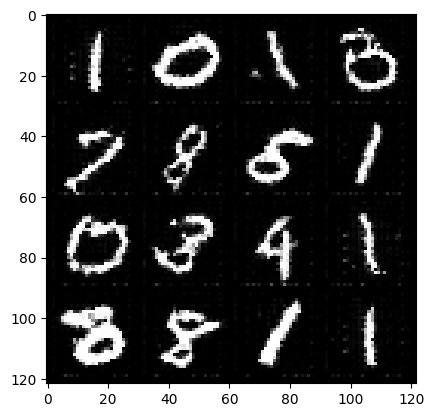

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:20 | D_loss:0.6437402967450969 | G_loss: 0.8221293185819695


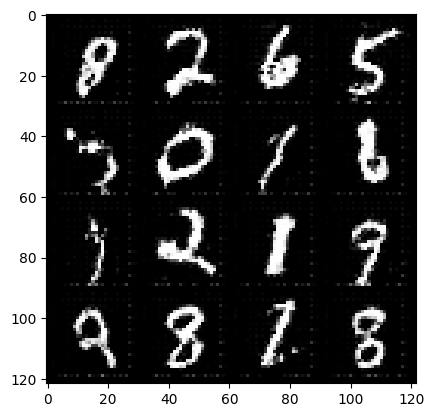

In [48]:
for i in range(epochs):
  total_d_loss=0.0
  total_g_loss=0.0

  for real_images, _ in tqdm(trainloader):
    real_img=real_images.to(device) # Corrected variable name from real_img to real_images
    noise=torch.randn(batch_size,noise_dim,device=device)
    #find loss and update weights for D
    D_opt.zero_grad()
    fake_images=G(noise)
    D_pred=D(fake_images) # Corrected variable name from fake_img to fake_images
    D_fake_loss=fake_loss(D_pred)

    D_pred=D(real_img) # Changed from real_images to real_img to ensure it's on the correct device
    D_real_loss=real_loss(D_pred)

    D_loss=(D_fake_loss+D_real_loss)/2
    total_d_loss+=D_loss.item()
    D_loss.backward()
    D_opt.step()

    #find loss and update weights for G
    G_opt.zero_grad()
    noise=torch.randn(batch_size,noise_dim,device=device)
    fake_images_for_gen_loss=G(noise) # Generate new fake images for G's loss
    D_pred=D(fake_images_for_gen_loss)
    G_loss=real_loss(D_pred)
    total_g_loss+=G_loss.item()
    G_loss.backward()
    G_opt.step()
  avg_d_loss= total_d_loss/len(trainloader)
  avg_g_loss= total_g_loss/len(trainloader)
  print("Epoch:{} | D_loss:{} | G_loss: {}".format(i+1,avg_d_loss,avg_g_loss))
  show_tensor_images(fake_images)

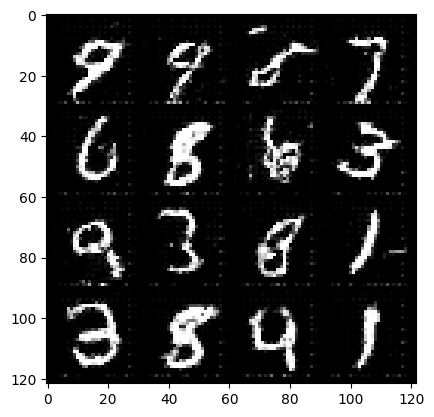

In [49]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)